# Gravity Model PPML Estimation

## Formalization of the gravity model equation
### with origin-destination (importer-exporter) fixed effects and lagged independent variables

\begin{equation}
\begin{split}
EXPORT_{ij,t} =\; &\exp\Bigl[\hat{\alpha}_{ij}
+ \sum_{k=1}^5 \hat{\beta}_{1k}\,GDP_{i,t-k}
+ \sum_{l=1}^5 \hat{\beta}_{2l}\,GDP_{j,t-l} \\
&\quad
+ \sum_{m=1}^5 \hat{\beta}_{3m}\,SANCT_{ij,t-m}\Bigr]
\times \epsilon_{ij,t}
\end{split}
\end{equation}

Where:
- $\hat\alpha_{ij}$ - time-invariant fixed effects
- $GDP_{i,t}$ - size of origin country $i$ at time $t$
- $GDP_{j,t}$ - size of destination country $j$ at time $t$
- $SANCT_{ij,t}$ - unilateral sanction relationship $i \rightarrow j$ at time $t$
- $\hat\beta_{1k}$, $\hat\beta_{2l}$, $\hat\beta_{3m}$ - estimated coefficients for the respective lagged variables
- $\epsilon_{ij,t}$ - error term


In [50]:
import gme
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celer import Lasso, LassoCV
from pandas import DataFrame
from scipy import sparse
from sklearn.model_selection import GroupShuffleSplit

import thesis_utils as tu

In [51]:
# Config for saving outputs
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"
VERBOSE = 0

# Model parameters
N_LAGS = 2
N_DYADS = 1000
MAX_ITERATIONS = 5000
SUBSAMPLE_ENABLED = False

# Train parameters
TARGET = "EXPORT"
PATIENCE = 15
RANDOM_SEED = 16

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

In [52]:
processed = pd.read_parquet(path="../../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [53]:
# Sort data by Report + Partner + Year
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"]).reset_index(drop=True)

In [54]:
if SUBSAMPLE_ENABLED:
  dyad_subsample = pd.Series(df["dyad_id"].unique()).sample(n=N_DYADS, random_state=RANDOM_SEED, replace=False)
  df = df[df["dyad_id"].isin(dyad_subsample)]
print(df["dyad_id"].nunique())

33672


In [55]:
df["GDP_reporter"] = np.log1p(df["GDP_reporter"]).astype(float)
df["GDP_partner"] = np.log1p(df["GDP_partner"]).astype(float)
df["EXPORT"] = np.log1p(df["EXPORT"])
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)
df["distw"] = np.log1p(df["distw"]).astype(float)

In [56]:
# Coerce numerical values
num_cols = ["distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", ]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)

In [57]:
lag_cols = ["GDP_reporter", "GDP_partner", "sanction"]
invariant_cols = ["contig", "comlang_off", "colony", "smctry", "distw"]

In [58]:
for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id")[col].shift(index)

df = df.dropna()

df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pd.Categorical(df[col], categories=sorted(df[col].unique()))

In [59]:
df = tu.add_fixed_effects(df)

Df Shape:  (1111203, 36)
Dummies Shape:  (1111203, 33671)
Final Df Shape:  (1111203, 33707)


In [60]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_df_idx, test_df_idx = next(gss.split(df, groups=df["dyad_id"]))
test_df = df.iloc[test_df_idx]
train_df = df.iloc[train_df_idx]

In [61]:
rhs_cols = [f"{c}_lag{index}" for c in lag_cols for index in range(1, N_LAGS + 1)]
fe_columns = [col for col in train_df.columns if col.startswith("fe_dyad_id_")]
convert_to_float_columns = rhs_cols + invariant_cols
train_df.loc[:, convert_to_float_columns] = train_df.loc[:, convert_to_float_columns].astype(
  "float32",
  copy=False
)
rhs_cols = rhs_cols + invariant_cols + fe_columns

print("Fixed effects columns:", fe_columns[:10])
print("Lagged columns:", rhs_cols[:15])

Fixed effects columns: ['fe_dyad_id_AGO_AND', 'fe_dyad_id_AGO_ARE', 'fe_dyad_id_AGO_ARG', 'fe_dyad_id_AGO_ARM', 'fe_dyad_id_AGO_ATG', 'fe_dyad_id_AGO_AUS', 'fe_dyad_id_AGO_AUT', 'fe_dyad_id_AGO_AZE', 'fe_dyad_id_AGO_BDI', 'fe_dyad_id_AGO_BEL']
Lagged columns: ['GDP_reporter_lag1', 'GDP_reporter_lag2', 'GDP_partner_lag1', 'GDP_partner_lag2', 'sanction_lag1', 'sanction_lag2', 'contig', 'comlang_off', 'colony', 'smctry', 'distw', 'fe_dyad_id_AGO_AND', 'fe_dyad_id_AGO_ARE', 'fe_dyad_id_AGO_ARG', 'fe_dyad_id_AGO_ARM']


In [62]:
# Prepare data
print("Selecting columns based on rhs_cols...")
col_idx = [train_df.columns.get_loc(c) for c in rhs_cols]
print("Finished extracting raw features.")

Selecting columns based on rhs_cols...
Finished extracting raw features.


In [ ]:
print("Extracting features from train_df...", flush=True)
X = train_df.iloc[:, col_idx].to_numpy(dtype=float, copy=False)
print("Finished extracting features.")
print("Creating sparse matrix from features...")
X = sparse.csr_matrix(X, dtype=float)
print("Finished creating sparse matrix from features.")

Extracting features from train_df...


In [46]:
y = train_df["EXPORT"].to_numpy(dtype=np.float32)
print("Finished extracting target variable.")

Finished extracting target variable.


In [47]:
# 1) Cross-validated Lasso to pick alpha
lasso_cv = LassoCV(cv=5, max_iter=MAX_ITERATIONS, tol=1e-4,
                   verbose=VERBOSE, n_jobs=-1)
print("Fitting celer.LassoCV (5-fold, all CPUs)…")
lasso_cv.fit(X, y)
cv_coef = lasso_cv.coef_

Fitting celer.LassoCV (5-fold, all CPUs)…


In [48]:
# Scale down the chosen alpha if desired
best_alpha = lasso_cv.alpha_
print(f"Selected alpha from CV: {best_alpha:.3e}")

Selected alpha from CV: 9.561e-03


In [20]:
# 2) Build threshold grid from non-zero CV coefficients
nz = np.abs(cv_coef[cv_coef != 0])
if nz.size == 0:
  print("Warning: no non-zero coefficients found! Using fallback.")
  nz = np.array([1e-5])
min_c, max_c = nz.min(), nz.max()
threshold_grid = np.logspace(np.log10(min_c / 10),
                             np.log10(max_c / 10), 10)
print("Threshold grid:", threshold_grid)

# 3) Fit final Lasso at best_alpha
print("Fitting final celer.Lasso…")
lasso_full = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                   tol=1e-4,
                   verbose=VERBOSE)
lasso_full.fit(X, y)
full_coef = lasso_full.coef_

Threshold grid: [6.61181054e-05 1.50141256e-04 3.40941358e-04 7.74210986e-04
 1.75808137e-03 3.99225815e-03 9.06563562e-03 2.05862813e-02
 4.67474091e-02 1.06154202e-01]
Fitting final celer.Lasso…


In [21]:
# 4) Loop over thresholds, refit on selected features, and compute RMSE
results_threshold = {
  "thresholds": [],
  "errors": [],
  "n_columns": [],
  "selected_columns": []
}

for thr in threshold_grid:
  print(f"\nThreshold {thr:.5f}")
  idx = np.where(np.abs(full_coef) >= thr)[0]
  cols = [rhs_cols[i] for i in idx]
  print(f"  -> {len(cols)} features selected")

  Xr = X[:, idx]
  lasso_sub = Lasso(alpha=best_alpha, max_iter=MAX_ITERATIONS,
                    tol=1e-4, verbose=VERBOSE)
  lasso_sub.fit(Xr, y)
  y_pred = lasso_sub.predict(Xr)
  err = tu.rmse(y, y_pred)

  results_threshold["thresholds"].append(thr)
  results_threshold["errors"].append(err)
  results_threshold["n_columns"].append(len(cols))
  results_threshold["selected_columns"].append(cols)


Threshold 0.00007
  -> 17 features selected

Threshold 0.00015
  -> 17 features selected

Threshold 0.00034
  -> 17 features selected

Threshold 0.00077
  -> 16 features selected

Threshold 0.00176
  -> 16 features selected

Threshold 0.00399
  -> 16 features selected

Threshold 0.00907
  -> 16 features selected

Threshold 0.02059
  -> 16 features selected

Threshold 0.04675
  -> 14 features selected

Threshold 0.10615
  -> 11 features selected


In [22]:
best_idx = np.argmin(results_threshold["errors"])

best_rmse = results_threshold["errors"][best_idx]
best_columns = results_threshold["selected_columns"][best_idx]

print(f"Best RMSE: {best_rmse}")
print(f"Best columns ({len(best_columns)}):")
print(best_columns)

Best RMSE: 3.288249774498468
Best columns (17):
['GDP_reporter_lag1', 'GDP_reporter_lag2', 'GDP_reporter_lag3', 'GDP_reporter_lag4', 'GDP_reporter_lag5', 'GDP_partner_lag1', 'GDP_partner_lag3', 'GDP_partner_lag4', 'GDP_partner_lag5', 'sanction_lag1', 'sanction_lag2', 'sanction_lag3', 'contig', 'comlang_off', 'colony', 'smctry', 'distw']


In [23]:
train_df.loc[:, 'ISO3_reporter'] = pd.Series(train_df['ISO3_reporter'].values, index=train_df.index).astype(str)
train_df.loc[:, 'ISO3_partner'] = pd.Series(train_df['ISO3_partner'].values, index=train_df.index).astype(str)
train_df.loc[:, 'Year'] = pd.to_numeric(train_df['Year'], errors='coerce')

In [24]:
for col in best_columns:
  train_df.loc[:, col] = pd.to_numeric(train_df[col], errors='coerce', downcast="float")

In [25]:
# Create estimation object
gme_data = gme.EstimationData(
  data_frame=train_df,
  imp_var_name="ISO3_reporter",
  exp_var_name="ISO3_partner",
  trade_var_name=TARGET,
  year_var_name="Year"
)
gme_data

number of countries: 184 
number of exporters: 184 
number of importers: 184 
number of years: 30 
number of sectors: not_applicable 
dimensions: (781195, 33717)

In [26]:
# Create GME model
gme_model = gme.EstimationModel(
  estimation_data=gme_data,
  lhs_var="EXPORT",
  rhs_var=best_columns,
  drop_intratrade=True
)

In [27]:
# Conduct PPML estimation of coefficients
estimates = gme_model.estimate()

Estimation began at 03:50 PM  on Jun 22, 2025
Omitted Regressors: []
Estimation completed at 03:51 PM  on Jun 22, 2025


In [28]:
gme_model.ppml_diagnostics

Overfit Warning                             No
Number of Regressors Dropped                 0
Regressors with Zero Trade                  []
Regressors from User                        []
Regressors Perfectly Collinear              []
Completion Time                   0.03 minutes
dtype: object

In [29]:
# estimates.keys()
results = estimates['all']
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 EXPORT   No. Observations:               781195
Model:                            GLM   Df Residuals:                   781178
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3426e+06
Date:                Sun, 22 Jun 2025   Deviance:                   3.3945e+06
Time:                        15:51:00   Pearson chi2:                 2.90e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9169
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
GDP_reporter_lag1    -0.0015      0.007     -0.202      0.840      -0.016       0.013
GDP_reporter_lag2     0.1174      0.012      9.857      0.000       0.094       0.141
GDP_reporter_lag3    -0.0171      0.013     -1.306      0.192      -0.043       0.009
GDP_reporter_lag4     0.1425      0.014     10.205      0.000       0.115       0.170
GDP_reporter_lag5    -0.0291      0.009     -3.120      0.002      -0.047      -0.011
GDP_partner_lag1     -0.0414      0.005     -7.751      0.000      -0.052      -0.031
GDP_partner_lag3      0.0799      0.011      7.279      0.000       0.058       0.101
GDP_partner_lag4      0.0872      0.014      6.276      0.000       0.060       0.114
GDP_partner_lag5     -0.0672      0.009     -7.322      0.000      -0.085      -0.049
sanction_lag1        -0.0241      0.004     -6.418      0.000      -0.031      -0.017
sanction_lag2        -0.0092      0.005     -1.798      0.072      -0.019       0.001
sanction_lag3        -0.0633      0.004    -16.646      0.000      -0.071      -0.056
contig               -0.5377      0.008    -67.567      0.000      -0.553      -0.522
comlang_off           0.0163      0.003      4.752      0.000       0.010       0.023
colony                0.2687      0.009     31.413      0.000       0.252       0.286
smctry               -0.3649      0.012    -31.280      0.000      -0.388      -0.342
distw                -0.6141      0.001   -555.074      0.000      -0.616      -0.612
=====================================================================================
"""

In [30]:
betas = results.params
betas

GDP_reporter_lag1   -0.001491
GDP_reporter_lag2    0.117420
GDP_reporter_lag3   -0.017066
GDP_reporter_lag4    0.142482
GDP_reporter_lag5   -0.029060
GDP_partner_lag1    -0.041441
GDP_partner_lag3     0.079912
GDP_partner_lag4     0.087227
GDP_partner_lag5    -0.067219
sanction_lag1       -0.024054
sanction_lag2       -0.009183
sanction_lag3       -0.063329
contig              -0.537657
comlang_off          0.016255
colony               0.268738
smctry              -0.364904
distw               -0.614142
dtype: float64

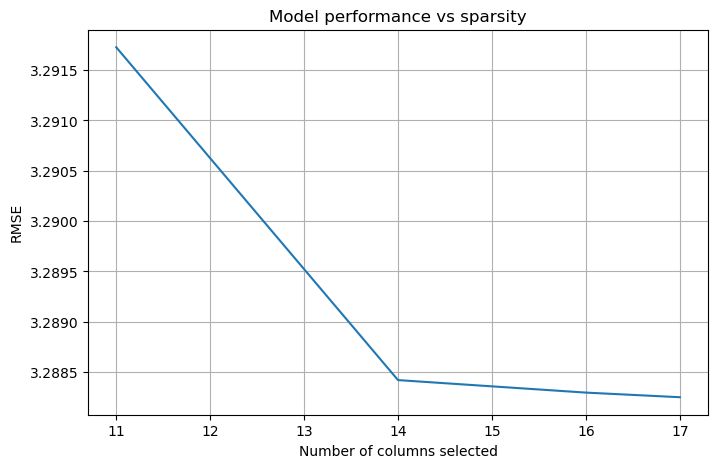

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(results_threshold["n_columns"], results_threshold["errors"])
plt.xlabel("Number of columns selected")
plt.ylabel("RMSE")
plt.title("Model performance vs sparsity")
plt.grid()
plt.show()

In [32]:
betas = gme_model.results_dict["all"].params

for col in best_columns:
  test_df.loc[:, col] = pd.to_numeric(test_df[col], errors="coerce")
test_df = test_df.dropna(subset=best_columns)
model_columns = betas.index.tolist()

In [33]:
missing_cols = [col for col in model_columns if col not in test_df.columns]
if missing_cols:
  print(f"Warning: The following columns are missing in test_df: {missing_cols}")
  for col in missing_cols:
    test_df[col] = 0.0

In [34]:
X_test = test_df[model_columns].values
beta_values = betas[model_columns].values
linear_combination = X_test @ beta_values
test_df["EXPORT_hat"] = np.exp(linear_combination)

In [35]:
y_true = test_df["EXPORT"].values
y_pred = test_df["EXPORT_hat"].values

print(f"RMSE: {tu.rmse(y_true, y_pred):.4f}")
print(f"MAE: {tu.mae(y_true, y_pred):.4f}")
print(f"RMAE: {tu.rmae(y_true, y_pred):.4f}")
print(f"Pseudo R²: {tu.pseudo_r2(y_true, y_pred):.4f}")
print(f"Within R²: {tu.within_r2(y_true, y_pred, test_df['dyad_id'].values):.4f}")

RMSE: 3.8394
MAE: 3.0154
RMAE: 0.8388
Pseudo R²: 0.3589
Within R²: -1.2297
